# 摘要

# 理论模型

鸡蛋，又名鸡卵、鸡子，是母鸡所产的卵，其外有一层硬壳，内则有气室、卵白及卵黄部分。鸡蛋中含有大量的维生素、矿物质及高价值的蛋白质，是人类最好的营养来源之一。因其具有营养丰富、饲料转化率较高、宗教饮食忌讳少等特点，一直是被世界广泛接受的畜产品。

![鸡蛋](.\images\鸡蛋.PNG)

## 分类

鸡蛋产品可以分为未经加工的鲜鸡蛋和以鲜鸡蛋为原料加工而成的蛋制品两种。在所有鸡蛋消费中，鲜鸡蛋消费超过 90%，占主导地位，蛋制品消费不足 10%。

鸡蛋分为土鸡蛋和洋鸡蛋。土鸡蛋指的是农家散养的土鸡所生的蛋。洋鸡蛋指的是养鸡场或养鸡专业户用合成饲料养的鸡生的蛋。从外观上基本无法区别土鸡蛋和洋鸡蛋。一般来说，土鸡蛋的蛋黄占蛋体比例大，洋鸡蛋的蛋黄占蛋体比例相对小，呈浅黄色。

鸡蛋按颜色分类：
* 绿壳蛋：蛋壳呈绿色的鸡蛋
* 白壳蛋：蛋壳浅色、白色的鸡蛋，此鸡蛋蛋壳薄、胆固醇低
* 褐壳蛋：是市面上比较常见的鸡蛋
* 七彩蛋：野鸡下的蛋，蛋壳五颜六色

## 价格影响因素

### 现货价格

鸡蛋作为日常消费品，需求比较稳定。一般，每年在端午节（5 月）和中秋节（9 月）会出现两个需求小高峰，春节前后（2 月）会出现需求低谷。

# 实证分析


In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from WindPy import w
import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

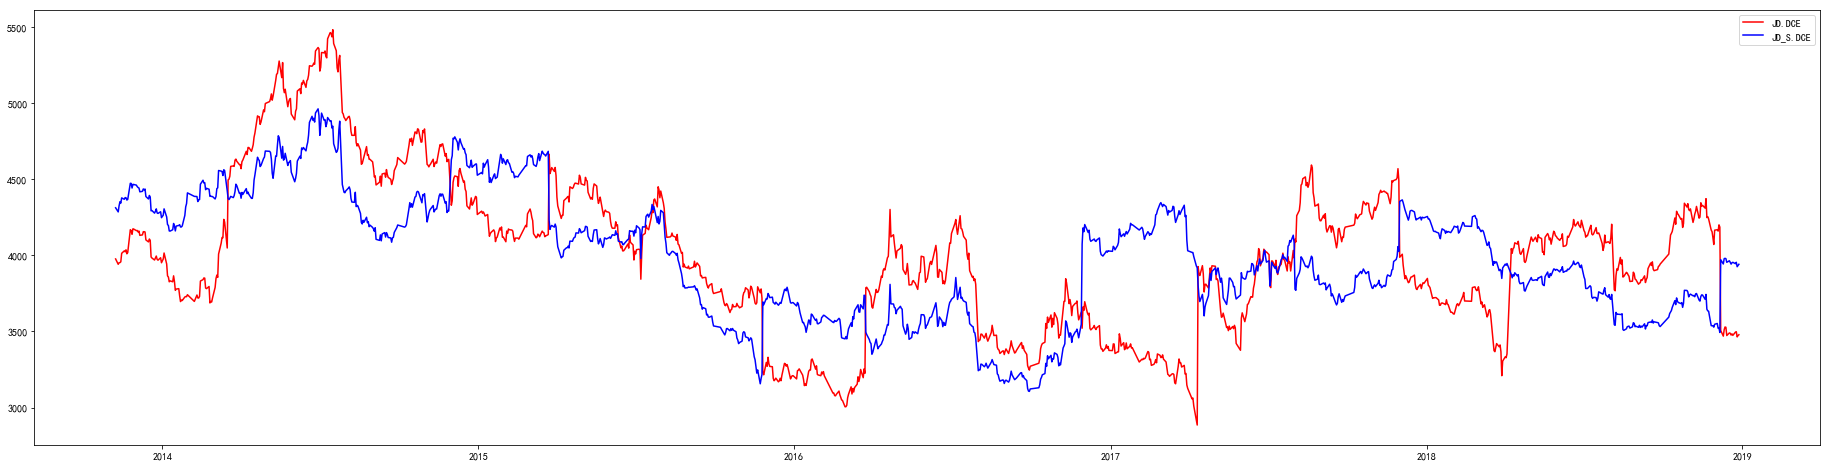

In [4]:
# 参数设置和数据准备
Exchange = "DCE"
MID, SID = "JD.DCE", "JD_S.DCE"# 主力合约, 次主力合约
StartDT = dt.datetime(2013, 11, 8)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0,:,:]
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=[PriceFactor], ids=[MID, SID], dts=DTs).iloc[0]
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = FT.readData(factor_names=[PriceFactor], ids=MonthIDs, dts=DTs).iloc[0]
WDB.disconnect()
# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CCPrice.columns}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(CCPrice.index, CCPrice.values[:, 0], color='r', label=CCPrice.columns[0])
Axes.plot(CCPrice.index, CCPrice.values[:, 1], color='b', label=CCPrice.columns[1])
Axes.legend(loc='best');

## 现货价格

* 鸡蛋现货(济南)
* 鸡蛋现货(山东青岛)

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


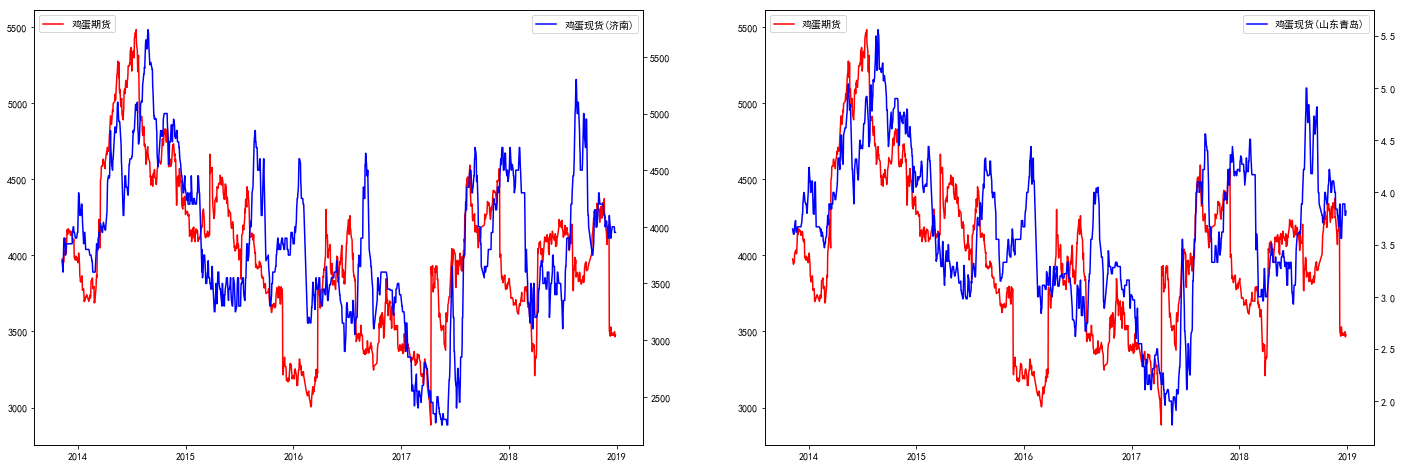

In [18]:
# 获取现货价格数据
SpotPrice = pd.DataFrame(index=DTs, columns=[])

w.start()
TempData = w.wsd("W00066SPT.NM,W00006SPT.NM", "close", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"), "")
TempData = pd.DataFrame(TempData.Data, index=["鸡蛋现货(济南)", "鸡蛋现货(山东青岛)"],
                        columns=[dt.datetime.combine(iDate, dt.time(0)) for iDate in TempData.Times]).T
SpotPrice = pd.merge(SpotPrice, TempData.loc[TempData.index.union(DTs)].fillna(method="pad").loc[DTs], left_index=True, right_index=True)
w.close()

import matplotlib.gridspec as gridspec
nID = SpotPrice.shape[1]
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(CCPrice.index, CCPrice.values[:,0], color='r', label="鸡蛋期货")
    iAxes.legend(loc='upper left')
    RAxes = iAxes.twinx()
    RAxes.plot(SpotPrice.index, SpotPrice.values[:, i], color='b', label=SpotPrice.columns[i])
    RAxes.legend(loc='upper right');

In [20]:
# --------Granger 因果检验: 现货价格是否为期货价格的 Granger 成因 --------
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.log(np.c_[CCPrice.values[:, 0], SpotPrice.values[:, 1]]), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0682  , p=0.7940  , df_denom=1254, df_num=1
ssr based chi2 test:   chi2=0.0684  , p=0.7937  , df=1
likelihood ratio test: chi2=0.0684  , p=0.7937  , df=1
parameter F test:         F=0.0682  , p=0.7940  , df_denom=1254, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1224  , p=0.8848  , df_denom=1251, df_num=2
ssr based chi2 test:   chi2=0.2457  , p=0.8844  , df=2
likelihood ratio test: chi2=0.2457  , p=0.8844  , df=2
parameter F test:         F=0.1224  , p=0.8848  , df_denom=1251, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1703  , p=0.9165  , df_denom=1248, df_num=3
ssr based chi2 test:   chi2=0.5138  , p=0.9158  , df=3
likelihood ratio test: chi2=0.5137  , p=0.9159  , df=3
parameter F test:         F=0.1703  , p=0.9165  , df_denom=1248, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1456  , p=0.

In [21]:
# --------Granger 因果检验: 期货价格是否为现货价格的 Granger 成因 --------
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.log(np.c_[SpotPrice.values[:, 1], CCPrice.values[:, 0]]), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9868  , p=0.0016  , df_denom=1254, df_num=1
ssr based chi2 test:   chi2=10.0107 , p=0.0016  , df=1
likelihood ratio test: chi2=9.9710  , p=0.0016  , df=1
parameter F test:         F=9.9868  , p=0.0016  , df_denom=1254, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.4531 , p=0.0000  , df_denom=1251, df_num=2
ssr based chi2 test:   chi2=20.9897 , p=0.0000  , df=2
likelihood ratio test: chi2=20.8162 , p=0.0000  , df=2
parameter F test:         F=10.4531 , p=0.0000  , df_denom=1251, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.2265  , p=0.0000  , df_denom=1248, df_num=3
ssr based chi2 test:   chi2=24.8180 , p=0.0000  , df=3
likelihood ratio test: chi2=24.5758 , p=0.0000  , df=3
parameter F test:         F=8.2265  , p=0.0000  , df_denom=1248, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.5457  , p=0.

## 饲料价格

* 现货价格
* 期货价格

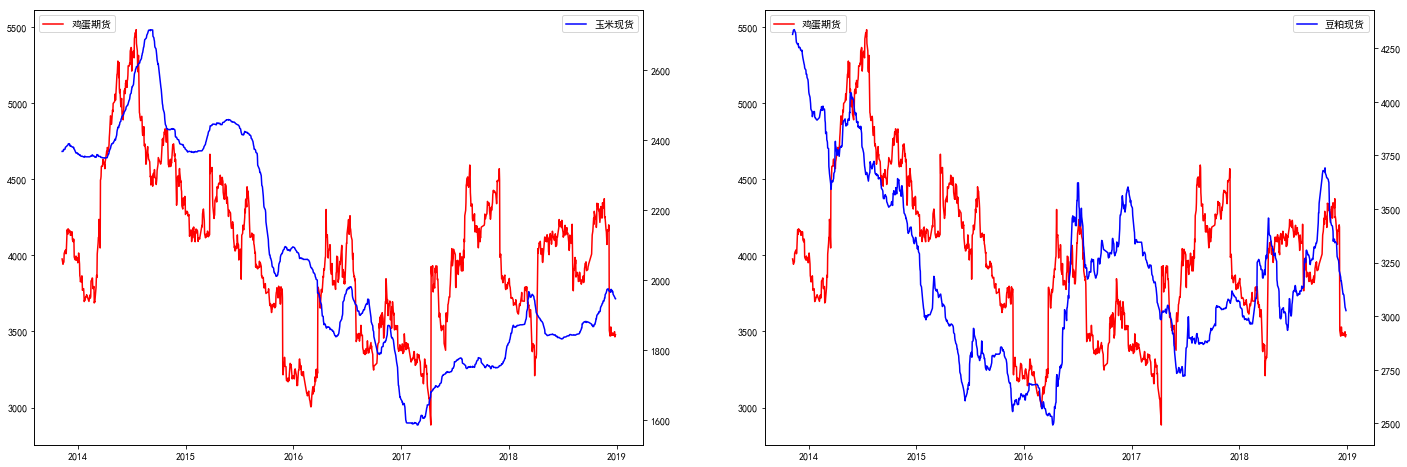

In [26]:
# 获取饲料现货价格数据
FoddarSpotPrice = pd.DataFrame(index=DTs, columns=[])

w.start()
TempData = w.wsd("W00001SPT.NM,W00003SPT.NM", "close", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"), "")
TempData = pd.DataFrame(TempData.Data, index=["玉米现货", "豆粕现货"],
                        columns=[dt.datetime.combine(iDate, dt.time(0)) for iDate in TempData.Times]).T
FoddarSpotPrice = pd.merge(FoddarSpotPrice, TempData.loc[TempData.index.union(DTs)].fillna(method="pad").loc[DTs], left_index=True, right_index=True)
w.close()

import matplotlib.gridspec as gridspec
nID = FoddarSpotPrice.shape[1]
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(CCPrice.index, CCPrice.values[:,0], color='r', label="鸡蛋期货")
    iAxes.legend(loc='upper left')
    RAxes = iAxes.twinx()
    RAxes.plot(FoddarSpotPrice.index, FoddarSpotPrice.values[:, i], color='b', label=FoddarSpotPrice.columns[i])
    RAxes.legend(loc='upper right');

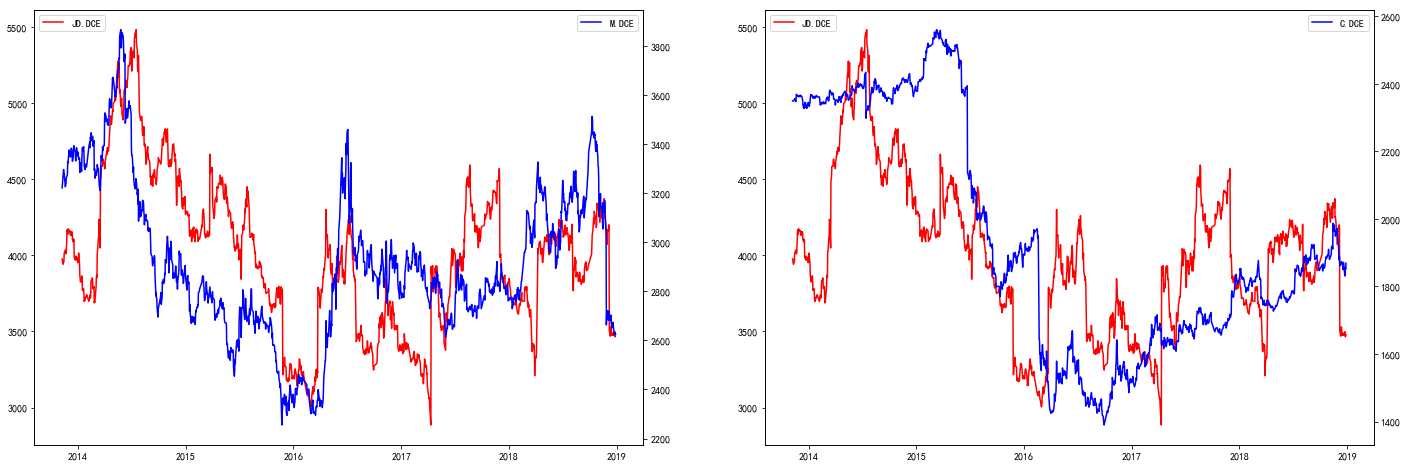

In [12]:
# 鸡蛋和豆粕, 玉米价格关系
FodderIDs = ["M.DCE", "C.DCE"]

WDB.connect()
# 获取价格数据
FT = WDB.getTable("中国商品期货日行情")
FodderPrice = FT.readData(factor_names=["收盘价(元)"], ids=FodderIDs, dts=DTs).iloc[0]
WDB.disconnect()

import matplotlib.gridspec as gridspec
nID = FodderPrice.shape[1]
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(CCPrice.index, CCPrice.values[:, 0], color='r', label="JD.DCE")
    iAxes.legend(loc='upper left')
    RAxes = iAxes.twinx()
    RAxes.plot(FodderPrice.index, FodderPrice.values[:, i], color='b', label=FodderIDs[i])
    RAxes.legend(loc='upper right');

In [16]:
# --------Granger 因果检验: 豆粕价格是否为鸡蛋价格的 Granger 成因 --------
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.log(np.c_[CCPrice.values[:, 0], FodderPrice.values[:, 0]]), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8351  , p=0.0504  , df_denom=1254, df_num=1
ssr based chi2 test:   chi2=3.8442  , p=0.0499  , df=1
likelihood ratio test: chi2=3.8384  , p=0.0501  , df=1
parameter F test:         F=3.8351  , p=0.0504  , df_denom=1254, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9352  , p=0.1448  , df_denom=1251, df_num=2
ssr based chi2 test:   chi2=3.8860  , p=0.1433  , df=2
likelihood ratio test: chi2=3.8800  , p=0.1437  , df=2
parameter F test:         F=1.9352  , p=0.1448  , df_denom=1251, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3480  , p=0.2573  , df_denom=1248, df_num=3
ssr based chi2 test:   chi2=4.0668  , p=0.2543  , df=3
likelihood ratio test: chi2=4.0602  , p=0.2550  , df=3
parameter F test:         F=1.3480  , p=0.2573  , df_denom=1248, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0484  , p=0.

In [14]:
# --------Granger 因果检验: 玉米价格是否为鸡蛋价格的 Granger 成因 --------
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.log(np.c_[CCPrice.values[:, 0], FodderPrice.values[:, 1]]), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2806  , p=0.1313  , df_denom=1254, df_num=1
ssr based chi2 test:   chi2=2.2861  , p=0.1305  , df=1
likelihood ratio test: chi2=2.2840  , p=0.1307  , df=1
parameter F test:         F=2.2806  , p=0.1313  , df_denom=1254, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5031  , p=0.2228  , df_denom=1251, df_num=2
ssr based chi2 test:   chi2=3.0183  , p=0.2211  , df=2
likelihood ratio test: chi2=3.0147  , p=0.2215  , df=2
parameter F test:         F=1.5031  , p=0.2228  , df_denom=1251, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9453  , p=0.4180  , df_denom=1248, df_num=3
ssr based chi2 test:   chi2=2.8519  , p=0.4150  , df=3
likelihood ratio test: chi2=2.8486  , p=0.4156  , df=3
parameter F test:         F=0.9453  , p=0.4180  , df_denom=1248, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9377  , p=0.

In [17]:
# --------Granger 因果检验: 鸡蛋价格是否为豆粕价格的 Granger 成因 --------
GrangerCausalityTest = sm.tsa.stattools.grangercausalitytests(x=np.log(np.c_[FodderPrice.values[:, 0], CCPrice.values[:, 0]]), maxlag=20)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0782  , p=0.7798  , df_denom=1254, df_num=1
ssr based chi2 test:   chi2=0.0784  , p=0.7795  , df=1
likelihood ratio test: chi2=0.0784  , p=0.7795  , df=1
parameter F test:         F=0.0782  , p=0.7798  , df_denom=1254, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4297  , p=0.6508  , df_denom=1251, df_num=2
ssr based chi2 test:   chi2=0.8628  , p=0.6496  , df=2
likelihood ratio test: chi2=0.8625  , p=0.6497  , df=2
parameter F test:         F=0.4297  , p=0.6508  , df_denom=1251, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3198  , p=0.8111  , df_denom=1248, df_num=3
ssr based chi2 test:   chi2=0.9648  , p=0.8098  , df=3
likelihood ratio test: chi2=0.9644  , p=0.8099  , df=3
parameter F test:         F=0.3198  , p=0.8111  , df_denom=1248, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3823  , p=0.

## 替代品

* 猪肉价格
    - 猪肉平均批发价，频率：日，单位：元/公斤，来源：农业部

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


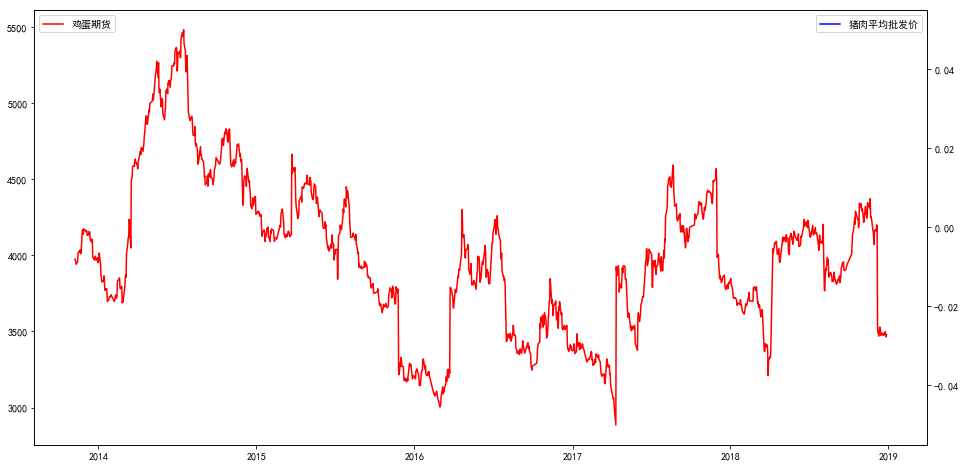

In [23]:
# 提取替代品价格
PorkPrice = pd.DataFrame(index=DTs, columns=[])

w.start()
TempData = w.edb("S5065106", "close", StartDT.strftime("%Y-%m-%d"), EndDT.strftime("%Y-%m-%d"), "Fill=Previous")
TempData = pd.DataFrame(TempData.Data, index=["猪肉平均批发价"],
                        columns=[dt.datetime.combine(iDate, dt.time(0)) for iDate in TempData.Times]).T
PorkPrice = pd.merge(PorkPrice, TempData.loc[TempData.index.union(DTs)].fillna(method="pad").loc[DTs], left_index=True, right_index=True)
w.close()

import matplotlib.gridspec as gridspec
nID = PorkPrice.shape[1]
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(CCPrice.index, CCPrice.values[:,0], color='r', label="鸡蛋期货")
    iAxes.legend(loc='upper left')
    RAxes = iAxes.twinx()
    RAxes.plot(PorkPrice.index, PorkPrice.values[:, i], color='b', label=PorkPrice.columns[i])
    RAxes.legend(loc='upper right');

# 附录

## 期货合约

![鸡蛋期货合约](.\images\鸡蛋期货合约.PNG)

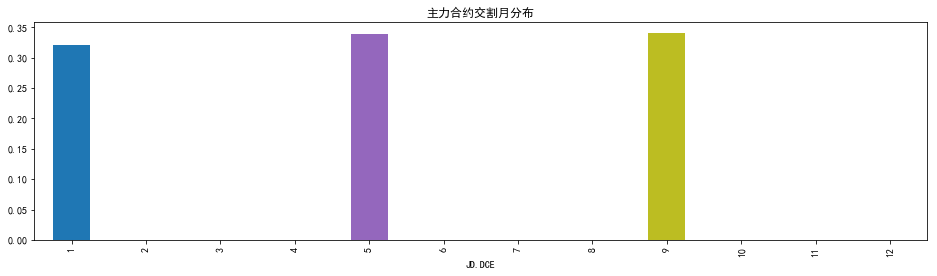

In [5]:
# 获取主力合约的月合约的交割月分布
import re
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
ExpiryMonthDistribution = ExpiryMonth.groupby(by=ExpiryMonth).count() / ExpiryMonth.shape[0]
ExpiryMonthDistribution = ExpiryMonthDistribution.loc[np.arange(1, 13)].fillna(0)
ExpiryMonthDistribution.plot(kind="bar", figsize=(16, 4), title="主力合约交割月分布");

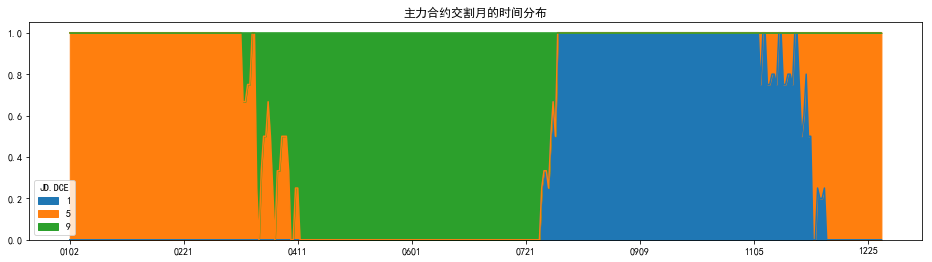

In [6]:
# 获取主力合约切换的时间分布
ExpiryMonth = FutureIDMap[MID].apply(lambda x: int(re.sub("\D", "", x)[-2:]))
MonthDay = pd.Series([iDT.strftime("%m%d") for iDT in ExpiryMonth.index], index=ExpiryMonth.index)
ExpiryMonthDistributionPerYear = ExpiryMonth.groupby(by=[ExpiryMonth, MonthDay]).count().unstack()
ExpiryMonthDistributionPerYear = (ExpiryMonthDistributionPerYear / ExpiryMonth.groupby(by=MonthDay).count()).T
ExpiryMonthDistributionPerYear = ExpiryMonthDistributionPerYear.fillna(0)
Fig, Axes = plt.subplots(1, 1, figsize=(16, 4))
Axes = ExpiryMonthDistributionPerYear.plot(kind="area", ax=Axes, title="主力合约交割月的时间分布")
xTicks = Axes.get_xticks().astype(np.int)
xTickLabels = np.full(shape=xTicks.shape, fill_value="", dtype="O")
Mask = ((xTicks>=0) & (xTicks<ExpiryMonthDistributionPerYear.shape[0]))
xTickLabels[Mask] = ExpiryMonthDistributionPerYear.index.values[xTicks[Mask].tolist()]
Axes.set_xticklabels(xTickLabels);